# Analysing topics

In [1]:
#import necessary packages
import re
import string
import json
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from html import unescape
from string import punctuation
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
from sklearn.manifold import TSNE
from scipy.spatial.distance import cosine
from nltk.util import bigrams
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel, BertTokenizer
from datetime import datetime 


### Load self-trained embeddings

In [2]:
from gensim.models import LdaModel
from gensim.models import FastText
from pprint import pprint

In [3]:
lda_physics = LdaModel.load("tuned_lda_model_210502")

In [5]:
embedding_1995 = FastText.load("model_FastText_1995_embedding_alinged_to_2015") # model_FastText_1995_embedding_alinged_to_2015
embedding_2005 = FastText.load("model_FastText_2005_embedding_alinged_to_2015")
embedding_2015 = FastText.load("model_FastText_embedding_2015")

### Create TSNE for abstracts

In [5]:
# Sklearn Stop words
from sklearn.feature_extraction import stop_words
stop_words = list(stop_words.ENGLISH_STOP_WORDS) + ['t', 's','from', 'subject', 're', 'edu', 'use']

/Users/alexandrarottenkolber/opt/anaconda3/envs/nlp/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [6]:
# load in physics abstracts 
with open('./phys_abstracts_tokenised.txt', 'r') as infile:
    phys_abstracts_tokenised = json.load(infile)
infile.close()

In [29]:
len(phys_abstracts_tokenised)

1128407

In [21]:
#Embeddings have the following shape: norm & dimension
np.linalg.norm(embedding_2015.wv["radiation"]), len(embedding_2015.wv["radiation"])

(1.0, 100)

In [24]:
# Define function to compute abstract embedding
def abs2vector(abstract, embedding):
    return np.mean([embedding.wv[w] for w in abstract if w in embedding.wv.index2entity and w not in stop_words], axis=0)

In [25]:
# calculate vectors for every abstract
review2vector_dic = {}

counter = 0
for abstract in sample_docs: 
    review2vector_dic[counter] = abs2vector(abstract, embedding_1995)
    counter += 1

In [27]:
len(embedding_1995.wv.index2entity) # number of unique words

6655

In [2]:
# load labelled data
with open('./phys_all_label.txt', 'r') as infile:
    phys_all_label = json.load(infile)
infile.close()

In [29]:
# filter select subsets of the different categories 
astro_abstr = pd.DataFrame(random.sample(list(phys_all_label["astro"].values()), 833))
condensed_abstr = pd.DataFrame(random.sample(list(phys_all_label["condensedm"].values()), 833))
general_abstr = pd.DataFrame(random.sample(list(phys_all_label["general"].values()), 833))

In [30]:
astro_abstr["label"] = "Astrophysics"
condensed_abstr["label"] = "Condensed Matter"
general_abstr["label"] = "General Pysics"

In [31]:
label_df = pd.concat([astro_abstr, condensed_abstr, general_abstr]).reset_index().drop(columns = ["index"])
label_df.head(3)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed,year,label
0,0803.0773,Paul Shankland,"Paul D. Shankland, David L. Blank, David A. Bo...",Further Constraints on the Presence of a Debri...,Accepted for publication in Astonomical Journa...,None,10.1088/0004-6256/135/6/2194,None,astro-ph,http://arxiv.org/licenses/nonexclusive-distrib...,Using both the Very Large Array (VLA) at 7mm...,"[{'version': 'v1', 'created': 'Thu, 6 Mar 2008...",2009-11-13,"[[Shankland, Paul D., ], [Blank, David L., ], ...",2008,Astrophysics
1,1907.01138,John Westernacher-Schneider,"John Ryan Westernacher-Schneider, Evan O'Conno...",Multimessenger Asteroseismology of Core-Collap...,"25 pages, 16 figures. Version accepted to PRD....","Phys. Rev. D 100, 123009 (2019)",10.1103/PhysRevD.100.123009,15 December 2019 issue of Physical Review D (V...,astro-ph.HE gr-qc,http://arxiv.org/licenses/nonexclusive-distrib...,We investigate correlated gravitational wave...,"[{'version': 'v1', 'created': 'Tue, 2 Jul 2019...",2019-12-18,"[[Westernacher-Schneider, John Ryan, ], [O'Con...",2019,Astrophysics
2,astro-ph/0407602,Naomi Ota,"Naomi Ota, Kazuhisa Mitsuda",A uniform X-ray analysis of 79 distant galaxy ...,"23 pages, 21 figures; minor corrections. To ap...",Astron.Astrophys. 428 (2004) 757-779,10.1051/0004-6361:20041087,None,astro-ph,None,We present a uniform analysis of the ROSAT H...,"[{'version': 'v1', 'created': 'Thu, 29 Jul 200...",2009-11-10,"[[Ota, Naomi, ], [Mitsuda, Kazuhisa, ]]",2004,Astrophysics


In [32]:
# function to tokenize abstract
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')

def tokenize_abstract(abstract):
    abstract = abstract.lower()  # Convert to lowercase.
    abstract = tokenizer.tokenize(abstract)  # Split into words
    
    return abstract

In [33]:
label_df["tokenised_abstract"] = label_df["abstract"].map(lambda x: tokenize_abstract(x))
label_df["abs2vector"] = label_df["abstract"].map(lambda x: abs2vector(x, embedding_1995))

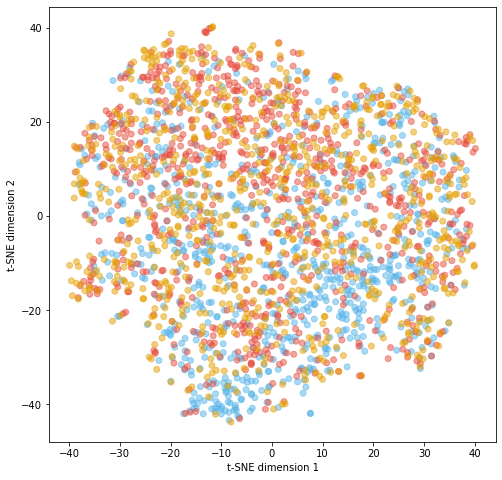

In [35]:
tsne_vectors = np.array(list(label_df['abs2vector']))

# Train t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1500, random_state=123)
tsne_results = tsne.fit_transform(tsne_vectors)

# Plot results
#'#56B4E9',   '#E69F00', '#E74C3C'
category2color = {'Astrophysics': '#56B4E9', 'Condensed Matter': '#E74C3C', 'General Pysics': '#E69F00'}
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.scatter(tsne_results[:, 0], 
           tsne_results[:, 1], 
           color= [category2color[c] for c in label_df['label']], 
           alpha = 0.5, 
           label=['Other', 'Condensed matter physics','Astrophysics'])
#ax.set_title('t-SNE plot of 2500 randomly sampled review embeddings')
#plt.legend(title = "Category", labels=[ 'Other', 'Condensed matter physics','Astrophysics'])
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')

#legend1 = ax.legend(*scatter.legend_elements(),
                    #loc="lower left", title="Classes")
#ax.add_artist(legend1)


plt.savefig("FastText_TSNE_plot_topics2vec_1995_2500_random_sampled_abstracts_with_label_colours.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

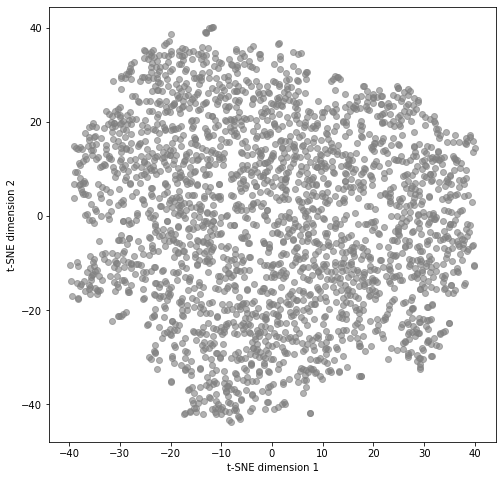

In [36]:
#tsne_vectors = np.array(list(label_df['abs2vector']))

# Train t-SNE
#tsne = TSNE(n_components=2, verbose=0, perplexity=50, n_iter=1500, random_state=123)
#tsne_results = tsne.fit_transform(tsne_vectors)

# Plot results
#'#56B4E9',   '#E69F00', '#E74C3C'
#category2color = {'Astrophysics': '#56B4E9', 'Condensed Matter': '#E74C3C', 'General Pysics': '#E69F00'}
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], alpha = 0.6, color= "grey")
#ax.set_title('t-SNE plot of 2500 randomly sampled review embeddings')
ax.set_xlabel('t-SNE dimension 1')
ax.set_ylabel('t-SNE dimension 2')



plt.savefig("FastText_TSNE_plot_topics2vec_1995_2500_random_sampled_abstracts_with_label_no_colours.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

### How the center of topics moved

In [6]:
# load data in 
with open('./corpus_all_phys_phys_1127486_complete.txt', 'r') as infile:
    corpus_phys_all_sample = json.load(infile)
infile.close()

In [8]:
# get top topics
top_topics = lda_physics.top_topics(corpus_phys_all_sample, topn=20)
pprint(len(top_topics))

50


In [9]:
topic2words = {}
for num, topics in enumerate(top_topics):
    words = []
    for tup in topics[0]: 
        words.append(tup[1])
        
    topic2words[num] = words

In [15]:
topics_df = pd.DataFrame.from_dict(topic2words, orient = "index").reset_index().rename(columns = {"index": "Topic"})
topics_df.head()

,Topic,0,1,2,3,4,5,6,7,8,...,10,11,12,13,14,15,16,17,18,19
0,0,phase,transition,critical,temperature,phase_transition,model,order,point,system,...,finite,two,field,disorder,phase_diagram,study,lattice,behavior,first,parameter
1,1,solar,flux,flare,region,observation,coronal,cycle,observed,sun,...,wind,event,time,active,loop,magnetic,wa,corona,data,tube
2,2,model,result,method,parameter,data,simulation,agreement,using,numerical,...,used,good,obtained,based,approach,account,theoretical,monte,carlo,present
3,3,spin,state,topological,lattice,model,quantum,system,interaction,ground,...,ground_state,two,symmetry,chain,dimensional,insulator,one,energy,fermion,band
4,4,distance,velocity,galactic,motion,km,radial,way,kpc,pc,...,disk,arm,spiral,milky_way,proper,star,center,cloud,gaia,data


In [46]:
# get weights of the topcis
weights = []
for tup in top_topics[1][0]: 
    weights.append(tup[0])

In [54]:
# Define function to compute mean 
def topic2vector(topic, embedding):
    return np.mean([embedding.wv[w] for w in topic if w in embedding.wv.index2entity and w not in stop_words], axis=0)

In [55]:
# Define function to compute weigthed mean 
def topic2weigthedvector(top_topic, embedding):
    weights = []
    for tup in top_topic[0]: 
        weights.append(tup[0])
    return np.mean([embedding.wv[tup[1]]*tup[0]/sum(weights) for tup in top_topic[0] if tup[1] in embedding.wv.index2entity and tup[1] not in stop_words], axis=0)

In [56]:
df = pd.DataFrame(list(range(0, 50)))
df["topic"] = topic2words.values()
df["weights_topic"] = top_topics
df_topic = df.copy()
df["topic2vector_1995"] = df["topic"].map(lambda x: topic2vector(x, embedding_1995))
df["topic2vector_2005"] = df["topic"].map(lambda x: topic2vector(x, embedding_2005))
df["topic2vector_2015"] = df["topic"].map(lambda x: topic2vector(x, embedding_2015))
df["topic2weightedcenter_1995"] = df["weights_topic"].map(lambda x: topic2weigthedvector(x, embedding_1995))
df["topic2weightedcenter_2005"] = df["weights_topic"].map(lambda x: topic2weigthedvector(x, embedding_2005))
df["topic2weightedcenter_2015"] = df["weights_topic"].map(lambda x: topic2weigthedvector(x, embedding_2015))

In [58]:
# function to calculate the difference between two vectors 
def calc_difference_between_vectors(v1, v2):
    diff = np.linalg.norm((v2 - v1))
    return diff

In [64]:
# apply function to the data and store it in a data frame
df["diff_2005_1995"] = df[['topic2vector_1995','topic2vector_2005']].apply(lambda x: calc_difference_between_vectors(*x), axis=1)
df["diff_2015_2005"] = df[['topic2vector_2015','topic2vector_2005']].apply(lambda x: calc_difference_between_vectors(*x), axis=1)
df["diff_2015_1995"] = df[['topic2vector_2015','topic2vector_1995']].apply(lambda x: calc_difference_between_vectors(*x), axis=1)

df["diff_weigthed_2005_1995"] = df[['topic2weightedcenter_1995','topic2weightedcenter_2005']].apply(lambda x: calc_difference_between_vectors(*x), axis=1)
df["diff_weigthed_2015_2005"] = df[['topic2weightedcenter_2015','topic2weightedcenter_2005']].apply(lambda x: calc_difference_between_vectors(*x), axis=1)
df["diff_weigthed_2015_1995"] = df[['topic2weightedcenter_2015','topic2weightedcenter_1995']].apply(lambda x: calc_difference_between_vectors(*x), axis=1)

In [65]:
df_disp = df.copy()

In [67]:
# filter data frame
df_disp_plot = df_disp[["diff_2015_1995", "diff_2005_1995", "diff_2015_2005"]].T.reset_index().copy()
df_disp_plot_weighted = df_disp[["diff_weigthed_2015_1995", "diff_weigthed_2005_1995", "diff_weigthed_2015_2005"]].T.reset_index().copy()
# get topics
topics = df_disp_plot_weighted.columns[1:]

In [70]:
df_disp_plot_weighted

,index,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,diff_weigthed_2015_1995,0.015817,0.018381,0.010458,0.012601,0.016443,0.015963,0.011133,0.012824,0.017191,...,0.014808,0.017774,0.013465,0.011925,0.022163,0.016800,0.014380,0.020886,0.020281,0.012492
1,diff_weigthed_2005_1995,0.013607,0.018056,0.007814,0.009661,0.016790,0.014783,0.008534,0.011223,0.016616,...,0.013888,0.016076,0.011833,0.010534,0.021736,0.012947,0.012819,0.018537,0.017849,0.009801
2,diff_weigthed_2015_2005,0.010164,0.014242,0.007331,0.008925,0.011518,0.010895,0.007318,0.010181,0.011338,...,0.008514,0.013118,0.008851,0.008605,0.016217,0.012601,0.010012,0.013319,0.011428,0.009716


##### Create plot for the topics that changed most

In [71]:
changedtopics = [] # get the topics that changed most
for topic in df_disp_plot_weighted.columns[1:]:
    if df_disp_plot.iloc[0][topic] - df_disp_plot.iloc[2][topic] > 0.085:
        changedtopics.append(topic)

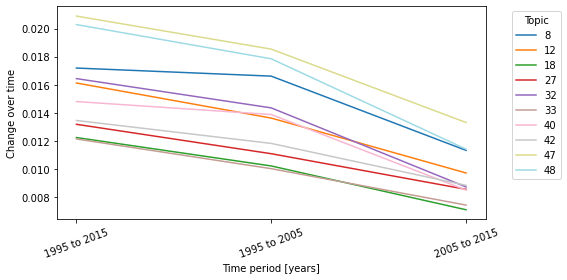

In [73]:
# create a plot of the 10 topics that changed most
df_disp_plot_weighted.plot(y = changedtopics, colormap = "tab20", figsize =(8, 4))
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks([0, 1, 2], ["1995 to 2015", "1995 to 2005", "2005 to 2015"], rotation=20) 
plt.xlabel("Time period [years]")
plt.ylabel("Change over time")

plt.tight_layout()

plt.savefig("FastText_Change_over_time_weighted_center.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

##### Create histplot for the movement of a topic's center

In [75]:
# filter data to generate the plot
diff_df_05_15 = pd.DataFrame()
diff_df_05_15["diff_between_years"] = df["diff_weigthed_2015_2005"]
diff_df_05_15["Year"] = "2005 to 2015"

diff_df_95_05 = pd.DataFrame()
diff_df_95_05["diff_between_years"] = df["diff_weigthed_2005_1995"]
diff_df_95_05["Year"] = "1995 to 2005"

diff_df_95_15 = pd.DataFrame()
diff_df_95_15["diff_between_years"] = df["diff_weigthed_2015_1995"]
diff_df_95_15["Year"] = "1995 to 2015"

diff_df = pd.concat([diff_df_95_15, diff_df_95_05, diff_df_05_15,]).reset_index()
diff_df.head(2)

,index,diff_between_years,Year
0,0,0.015817,1995 to 2015
1,1,0.018381,1995 to 2015


In [181]:
for data, year in [(diff_df_95_05, "1995 to 2005"), (diff_df_05_15, "2005 to 2015"), (diff_df_95_15, "1995 to 2015")]: 
    print(year)
    print(np.mean(data["diff_between_years"]), np.std(data["diff_between_years"]))

1995 to 2005
0.012978426273912191 0.0033972946042577765
2005 to 2015
0.010547287967056037 0.002433805124773173
1995 to 2015
0.01464887822046876 0.0033682130717143737


This difference is significant!

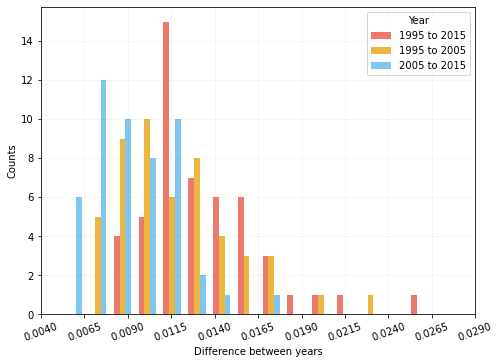

In [157]:
# Create an array with the colors to use
colors = ['#E74C3C', '#E69F00', '#56B4E9'] #'#F0E442']
sns.set_palette(sns.color_palette(colors))

ax = plt.figure(figsize = (7, 5))
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)

sns.histplot(diff_df, 
             x = "diff_between_years", 
             hue="Year", 
             multiple="dodge", 
             shrink=.7, 
             bins= 15, 
             edgecolor=None)
plt.xlabel("Difference between years")
plt.ylabel("Counts")
plt.xlim(0.155, 0.18)

plt.tight_layout()

plt.xticks([0.155, 0.1575, 0.160, 0.1625, 0.165, 0.1675, 0.170, 0.1725, 0.175, 0.1775, 0.180], ["0.0040", 0.0065, "0.0090", 0.0115, "0.0140", 0.0165, "0.0190", 0.0215, "0.0240", 0.0265, "0.0290"], rotation=20) 

plt.savefig("FastText_Change_over_time_weighted_center_hist.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

### How topics dispersed 

Here I checked the variance, e.g. the deviation from the mean (how far vectors are away from the mean)

In [81]:
# map word to vector
def map_word_to_vector(word_list, vectors):
    vectors_list = []
    for word in word_list: 
        if word in vectors.wv.index2entity:
            vectors_list.append(vectors.wv[word])
    return vectors_list

In [82]:
# apply function to data
df_disp["words2vectors_1995"] = df_disp["topic"].map(lambda x : map_word_to_vector(x, embedding_1995))
df_disp["words2vectors_2005"] = df_disp["topic"].map(lambda x : map_word_to_vector(x, embedding_2005))
df_disp["words2vectors_2015"] = df_disp["topic"].map(lambda x : map_word_to_vector(x, embedding_2015))

In [85]:
# write function to calculate the deviation of the center
def calculate_spread_from_center(list_of_vectors, topic_mean_vector):
    differences = []
    for word in list_of_vectors: 
        difference = (word - topic_mean_vector)
        norm = np.linalg.norm(difference)
        differences.append(norm)
        
    deviation = ((np.array([val**2 for val in differences]).sum())/ (len(differences)-1))**0.5
    return deviation

In [87]:
# apply the function
spread_1995 = []
spread_2005 = []
spread_2015 = []

for i in range(len(df_disp)):
    topic2vector_1995 = df_disp[["topic2weightedcenter_1995"]].iloc[i][0]
    words2vectors_1995 = df_disp[["words2vectors_1995"]].iloc[i][0]

    topic2vector_2005 = df_disp[["topic2weightedcenter_2005"]].iloc[i][0]
    words2vectors_2005 = df_disp[["words2vectors_2005"]].iloc[i][0]
    
    topic2vector_2015 = df_disp[["topic2weightedcenter_2015"]].iloc[i][0]
    words2vectors_2015 = df_disp[["words2vectors_2015"]].iloc[i][0]
    
    spread_1995.append(calculate_spread_from_center(words2vectors_1995, topic2vector_1995))
    spread_2005.append(calculate_spread_from_center(words2vectors_2005, topic2vector_2005))
    spread_2015.append(calculate_spread_from_center(words2vectors_2015, topic2vector_2015))
    
df_disp["spread_1995"] = pd.Series(spread_1995)
df_disp["spread_2005"] = pd.Series(spread_2005)
df_disp["spread_2015"] = pd.Series(spread_2015)

In [88]:
# a glance at the dataframe
df_disp.head(5)

,0,topic,weights_topic,topic2vector_1995,topic2vector_2005,topic2vector_2015,topic2weightedcenter_1995,topic2weightedcenter_2005,topic2weightedcenter_2015,diff_2005_1995,...,diff_2015_1995,diff_weigthed_2005_1995,diff_weigthed_2015_2005,diff_weigthed_2015_1995,words2vectors_1995,words2vectors_2005,words2vectors_2015,spread_1995,spread_2005,spread_2015
0,0,"(phase, transition, critical, temperature, pha...","([(0.093387544, phase), (0.05559666, transitio...","[-0.07353912, -0.057042684, -0.00071792776, 0....","[-0.04550588, -0.037181962, -0.022678366, 0.01...","[-0.04759157, -0.019518003, -0.026474228, 0.01...","[-0.005978246, -0.0038359442, -2.0424247e-06, ...","[-0.0019430908, -0.002584909, -0.0016314194, 0...","[-0.002239903, -0.0014546255, -0.003224111, 0....",0.194214,...,0.225561,0.013607,0.010164,0.015817,"[[-0.20308803, -0.1262759, 0.043883704, 0.2161...","[[-0.0003498029, -0.03895507, 0.033865932, 0.1...","[[-0.014668416, -0.014400473, -0.11933815, 0.1...",1.013804,1.012923,1.013866
1,1,"(solar, flux, flare, region, observation, coro...","([(0.03233045, solar), (0.012671981, flux), (0...","[-0.011938055, -0.03265911, -0.027819138, -0.0...","[-0.010491119, -0.026501248, -0.058767486, -0....","[0.028163446, -0.031999093, -0.015680421, -0.0...","[-0.00047638023, -0.0015319933, -0.0027639037,...","[-0.0019081745, -0.0007473723, -0.0029710524, ...","[0.00067553145, -0.0010135068, -0.00046569525,...",0.232278,...,0.246401,0.018056,0.014242,0.018381,"[[-0.011951368, -0.033993054, -0.12581488, -0....","[[-0.16885768, 0.023379358, -0.08375238, -0.17...","[[-0.10028275, 0.033816602, -0.0048489626, -0....",1.021661,1.019943,1.020548
2,2,"(model, result, method, parameter, data, simul...","([(0.07031522, model), (0.026030345, result), ...","[0.01449197, -0.14068547, -0.046024114, -0.068...","[0.018605111, -0.13627988, -0.057254888, -0.08...","[0.017507192, -0.13921458, -0.037896622, -0.06...","[0.0011825317, -0.0061549703, -0.0010984477, -...","[0.0016917263, -0.006158297, -0.0028766436, -0...","[0.0016006723, -0.006160517, -0.0011314849, -0...",0.142536,...,0.179872,0.007814,0.007331,0.010458,"[[0.047659006, -0.03905343, 0.072136275, -0.07...","[[0.07552122, -0.043925688, -0.07193323, -0.02...","[[0.089564584, -0.0488304, 0.045553565, -0.055...",1.014395,1.012783,1.012887
3,3,"(spin, state, topological, lattice, model, qua...","([(0.03485569, spin), (0.030900031, state), (0...","[-0.060472798, 0.008680473, -0.06743901, -0.05...","[-0.028785156, 0.018444045, -0.10107843, -0.02...","[-0.04121856, 0.020031435, -0.08081717, -0.002...","[-0.0027740519, 0.00091550604, -0.004718527, -...","[-0.0011849322, 0.00042954547, -0.006046293, -...","[-0.0016471854, 0.00088055007, -0.0061784326, ...",0.175370,...,0.226404,0.009661,0.008925,0.012601,"[[-0.07070736, 0.05836922, -0.18652044, 0.0164...","[[-0.05381573, 0.031703442, -0.28727862, 0.046...","[[-0.03343604, 0.07272164, -0.33330932, 0.0611...",1.015721,1.014159,1.014164
4,4,"(distance, velocity, galactic, motion, km, rad...","([(0.049435146, distance), (0.036876686, veloc...","[-0.028210191, -0.05967114, -0.049465403, -0.0...","[-0.015225146, -0.031549606, -0.020274675, -0....","[-0.029406918, -0.015705649, -0.059790798, -0....","[-0.0015090568, -0.0017484452, -0.002617637, -...","[0.0005855667, 2.4253814e-06, -0.001631237, -0...","[-0.00083858037, -0.00012537856, -0.002598971,...",0.239802,...,0.241865,0.016790,0.011518,0.016443,"[[0.014902471, -0.07195098, -0.02245331, -0.15...","[[0.11459212, 0.00033159181, -0.014609763, -0....","[[0.098869145, -0.006855237, 0.0017221839, -0....",1.024168,1.021562,1.021955


##### Plot the topics that dispersed most

In [89]:
# get a data frame 
df_disp_plot = df_disp[["spread_1995", "spread_2005", "spread_2015"]].T.reset_index().copy()
topics = df_disp_plot.columns[1:]

In [94]:
# filter the topics that dispersed most
dispersed_topics = []
for topic in df_disp_plot.columns[1:]:
    if df_disp_plot.iloc[0][topic] - df_disp_plot.iloc[2][topic] > 0.0032:
        dispersed_topics.append(topic)

In [95]:
len(dispersed_topics)

10

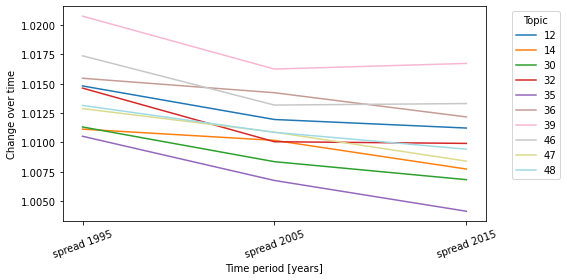

In [96]:
df_disp_plot.plot(y = dispersed_topics, colormap = "tab20", figsize =(8, 4))
plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks([0, 1, 2], ["spread 1995", "spread 2005", "spread 2015"], rotation=20) 
plt.xlabel("Time period [years]")
plt.ylabel("Change over time")

plt.tight_layout()

plt.savefig("FastText_Dispersion_over_time_weighted_center.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)


In [97]:
df_disp_plot

,index,0,1,2,3,4,5,6,7,8,...,40,41,42,43,44,45,46,47,48,49
0,spread_1995,1.013804,1.021661,1.014395,1.015721,1.024168,1.021154,1.013817,1.011649,1.014338,...,1.013928,1.017078,1.015300,1.011763,1.011819,1.016434,1.017381,1.012886,1.013156,1.011515
1,spread_2005,1.012923,1.019943,1.012783,1.014159,1.021562,1.019546,1.012743,1.010957,1.013077,...,1.011642,1.016674,1.012663,1.010786,1.012139,1.015966,1.013186,1.010880,1.010866,1.011346
2,spread_2015,1.013866,1.020548,1.012887,1.014164,1.021955,1.019415,1.013641,1.011328,1.012654,...,1.012006,1.017507,1.013131,1.011501,1.013037,1.013847,1.013314,1.008415,1.009430,1.010427


##### Create a histogram of topic's dispersion

In [99]:
spread_15 = pd.DataFrame()
spread_15["spread"] = df_disp["spread_2015"]
spread_15["Year"] = "2015"

spread_05 = pd.DataFrame()
spread_05["spread"] = df_disp["spread_2005"]
spread_05["Year"] = "2005"

spread_95 = pd.DataFrame()
spread_95["spread"] = df_disp["spread_1995"]
spread_95["Year"] = "1995"

spread_df = pd.concat([spread_95, spread_05, spread_15])
spread_df.head(2)

,spread,Year
0,1.013804,1995
1,1.021661,1995


In [153]:
for data, year in [(spread_95, 1995), (spread_05, 2005), (spread_15, 2015)]: 
    print(year)
    print(np.mean(data["spread"]), np.std(data["spread"]))

1995
1.0151692370279557 0.0032250406740577772
2005
1.0135410423858282 0.0032115383877164756
2015
1.0133171908333283 0.0036764712980222156


Differences are not significant!

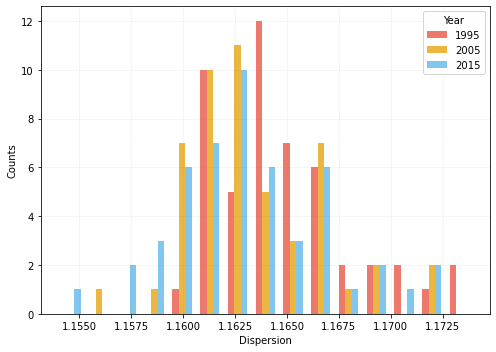

In [102]:
# Create an array with the colors you want to use
colors = ['#E74C3C','#E69F00', '#56B4E9']#, '#F0E442']
sns.set_palette(sns.color_palette(colors))

ax = plt.figure(figsize = (7, 5))
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)

sns.histplot(spread_df, 
             x = "spread", 
             hue="Year", 
             multiple="dodge",  
             shrink=.7, 
             bins= 15, 
             edgecolor=None)
plt.xlabel("Dispersion")
plt.ylabel("Counts")

plt.tight_layout()


plt.savefig("FastText_Dispersion_over_time_hist.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

### How topics rotated

In this section I calculated the angles between vectors.

In [109]:
# function to calculate the angles between different vectors
def caluclate_angles_between_words_and_topic_vector(list_word_vectors, topic_vector):
    cos_angles = []
    angles = [] 
    for vector in list_word_vectors: 
        dot_prod = np.dot(vector, topic_vector)
        norm_a = np.linalg.norm(vector)
        norm_b = np.linalg.norm(topic_vector)
        cos_angles.append(dot_prod / (norm_a * norm_b))
        angles.append(np.arccos(dot_prod / (norm_a * norm_b))) # in radians so [0, pi]
    
    return cos_angles, angles

In [110]:
# apply function to the data
angles_to_center_1995 = []
angles_to_center_2005 = []
angles_to_center_2015 = []

for i in range(len(df_disp)):
    topic2vector_1995 = df_disp[["topic2weightedcenter_1995"]].iloc[i][0]
    words2vectors_1995 = df_disp[["words2vectors_1995"]].iloc[i][0]

    topic2vector_2005 = df_disp[["topic2weightedcenter_2005"]].iloc[i][0]
    words2vectors_2005 = df_disp[["words2vectors_2005"]].iloc[i][0]
    
    topic2vector_2015 = df_disp[["topic2weightedcenter_2015"]].iloc[i][0]
    words2vectors_2015 = df_disp[["words2vectors_2015"]].iloc[i][0]
    
    angles_to_center_1995.append(caluclate_angles_between_words_and_topic_vector(words2vectors_1995, topic2vector_1995)[1])
    angles_to_center_2005.append(caluclate_angles_between_words_and_topic_vector(words2vectors_2005, topic2vector_2005)[1])
    angles_to_center_2015.append(caluclate_angles_between_words_and_topic_vector(words2vectors_2015, topic2vector_2015)[1])
    
    
df_disp["angles_to_center_1995"] = pd.Series(angles_to_center_1995)
df_disp["angles_to_center_2005"] = pd.Series(angles_to_center_2005)
df_disp["angles_to_center_2015"] = pd.Series(angles_to_center_2015)

In [111]:
df_disp["mean_angle_1995"] = df_disp["angles_to_center_1995"].map(lambda x: np.mean(x))
df_disp["mean_angle_2005"] = df_disp["angles_to_center_2005"].map(lambda x: np.mean(x))
df_disp["mean_angle_2015"] = df_disp["angles_to_center_2015"].map(lambda x: np.mean(x))

df_disp["std_angle_1995"] = df_disp["angles_to_center_1995"].map(lambda x: np.std(x))
df_disp["std_angle_2005"] = df_disp["angles_to_center_2005"].map(lambda x: np.std(x))
df_disp["std_angle_2015"] = df_disp["angles_to_center_2015"].map(lambda x: np.std(x))

#### Angle between words

In [113]:
from itertools import combinations

In [115]:
combi_of_words = [combo for combo in combinations(df_disp["topic"].iloc[0], 2)]

In [117]:
def caluclate_angles_between_words(combi_of_words, embedding):
    cos_angles = [] # costheta
    angles = [] #theta
    for tup in combi_of_words: 
        if tup[0] in embedding.wv.index2entity and tup[1] in embedding.wv.index2entity:
            vec1 = embedding.wv[tup[0]]
            vec2 = embedding.wv[tup[1]]
            dot_prod = np.dot(vec1, vec2)
            norm_a = np.linalg.norm(vec1)
            norm_b = np.linalg.norm(vec2)
            cos_angles.append(dot_prod / (norm_a * norm_b))
            angles.append(np.arccos(dot_prod / (norm_a * norm_b))) # in radians so [0, pi]
    
    return cos_angles, angles

In [120]:
angles_between_words_1995 = []
angles_between_words_2005 = []
angles_between_words_2015 = []


for i in range(len(df_disp)):
    combi_of_words = [combo for combo in combinations(df_disp["topic"].iloc[i], 2)]
    
    angles_between_words_1995.append(caluclate_angles_between_words(combi_of_words, embedding_1995)[1])
    angles_between_words_2005.append(caluclate_angles_between_words(combi_of_words, embedding_2005)[1])
    angles_between_words_2015.append(caluclate_angles_between_words(combi_of_words, embedding_2015)[1])
    
    
df_disp["angles_between_words_1995"] = pd.Series(angles_to_center_1995)
df_disp["angles_between_words_2005"] = pd.Series(angles_to_center_2005)
df_disp["angles_between_words_2015"] = pd.Series(angles_to_center_2015)


df_disp["mean_angle_between_words_1995"] = df_disp["angles_between_words_1995"].map(lambda x: np.mean(x))
df_disp["mean_angle_between_words_2005"] = df_disp["angles_between_words_2005"].map(lambda x: np.mean(x))
df_disp["mean_angle_between_words_2015"] = df_disp["angles_between_words_2015"].map(lambda x: np.mean(x))

df_disp["std_angle_between_words_1995"] = df_disp["angles_between_words_1995"].map(lambda x: np.std(x))
df_disp["std_angle_between_words_2005"] = df_disp["angles_between_words_2005"].map(lambda x: np.std(x))
df_disp["std_angle_between_words_2015"] = df_disp["angles_between_words_2015"].map(lambda x: np.std(x))

In [123]:
df_disp_T_mean = df_disp[["mean_angle_between_words_1995", "mean_angle_between_words_2005", "mean_angle_between_words_2015"]].T.reset_index()
df_disp_T_std = df_disp[["std_angle_between_words_1995", "std_angle_between_words_2005", "std_angle_between_words_2015"]].T.reset_index()

[entry for entry in df_disp_T_mean[0]]

[1.1561769247055054, 1.1372053623199463, 1.1597706079483032]

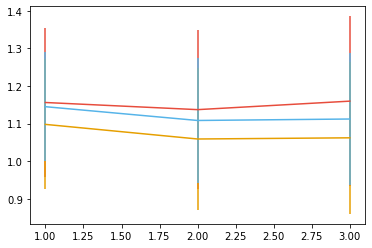

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# example data
y = [entry for entry in df_disp_T_mean[0]]
y_e = [entry for entry in df_disp_T_std[0]]
x = [1, 2, 3]

y3 = [entry for entry in df_disp_T_mean[3]]
y_e3 = [entry for entry in df_disp_T_std[3]]


y2 = [entry for entry in df_disp_T_mean[2]]
y_e2 = [entry for entry in df_disp_T_std[2]]

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=y_e)
ax.errorbar(x, y2, yerr=y_e2)
ax.errorbar(x, y3, yerr=y_e3)
plt.show()

Development is not significant!

In [127]:
df2015 = pd.DataFrame()
df2015["mean_angle_between_words"] = df_disp["mean_angle_between_words_2015"]
df2015["Year"] = "2015"
df2005 = pd.DataFrame()
df2005["mean_angle_between_words"] = df_disp["mean_angle_between_words_2005"]
df2005["Year"] = "2005"
df1995 = pd.DataFrame()
df1995["mean_angle_between_words"] = df_disp["mean_angle_between_words_1995"]
df1995["Year"] = "1995"

In [152]:
for data, year in [(df1995, 1995), (df2005, 2005), (df2015, 2015)]: 
    print(year)
    print(np.mean(data["mean_angle_between_words"]), np.std(data["mean_angle_between_words"]))

1995
1.0937983107566833 0.05063547129609529
2005
1.0566473865509034 0.05310335941149388
2015
1.0521140956878663 0.06095448540132442


Differences are not significant!

In [128]:
data_df = pd.concat([df1995, df2005,  df2015,])

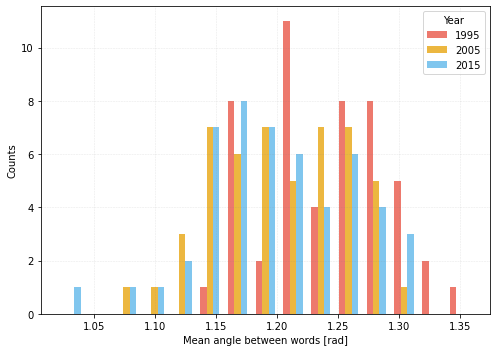

In [130]:
## Create an array with the colors
colors = ['#E74C3C', '#E69F00', '#56B4E9']
# Set custom color palette
sns.set_palette(sns.color_palette(colors))

ax = plt.figure(figsize = (7, 5))
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)

sns.histplot(data_df, 
             x = "mean_angle_between_words", 
             #color = colorscale, 
             hue="Year", 
             multiple="dodge", 
             #kde = True, 
             #stat= "probability", 
             shrink=.7, 
             bins= 15, 
             edgecolor=None)
             #edgecolors="red")#, hue = 0.5)
plt.xlabel("Mean angle between words [rad]")
plt.ylabel("Counts")

plt.tight_layout()

plt.savefig("FastText_Angle_over_time_hist.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

In [132]:
df20152 = pd.DataFrame()
df20152["mean_angle_words_topic"] = df_disp["mean_angle_2015"]
df20152["Year"] = "2015"
df20052 = pd.DataFrame()
df20052["mean_angle_words_topic"] = df_disp["mean_angle_2005"]
df20052["Year"] = "2005"
df19952 = pd.DataFrame()
df19952["mean_angle_words_topic"] = df_disp["mean_angle_1995"]
df19952["Year"] = "1995"

data_df2 = pd.concat([df19952, df20052,  df20152,])

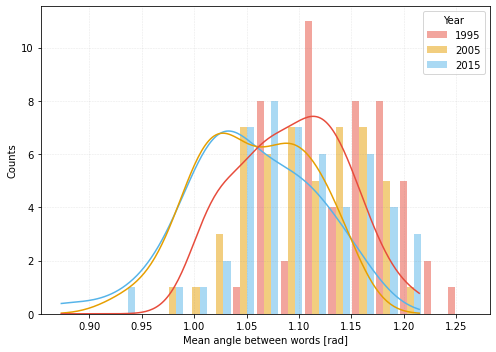

In [135]:
ax = plt.figure(figsize = (7, 5))
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)

sns.histplot(data_df2, 
             x = "mean_angle_words_topic",  
             hue="Year", 
             multiple="dodge", 
             kde = True, 
             shrink=.9, 
             bins= 15, 
             edgecolor=None)
plt.xlabel("Mean angle between words [rad]")
plt.ylabel("Counts")

plt.tight_layout()

# Which document is assinged witch topic

In [7]:
with open('./abs2year_dic.txt', 'r') as infile:
    abs2year_dic = json.load(infile)
infile.close()

In [13]:
abstracts_to_be_transformed = []
for key in abs2year_dic.keys(): 
    abstracts_to_be_transformed.append(abs2year_dic[key]["abstract"])

In [14]:
# Create corpus

from gensim.corpora import Dictionary

dictionary_docs = Dictionary(abstracts_to_be_transformed)

# Filter out words that occur in less than 20 documents, or more than 50% of the documents.
dictionary_docs.filter_extremes(no_below=20, no_above=0.4)
corpus_docs = [dictionary_docs.doc2bow(doc) for doc in abstracts_to_be_transformed]

In [16]:
# create dictionary that has the abstracts, years and BOW representation of docs
abs2BOW_year_dic = abs2year_dic.copy()
for num, bow_doc in enumerate(corpus_docs): 
    abs2BOW_year_dic[str(num)]["BOW"] = bow_doc

#### Plot a histogram of how many papers were published each year for each topic 

In [32]:
doc2topic_year_abs = {}
for key in abs2BOW_year_dic.keys():
    assignment_doc = lda_physics.get_document_topics(abs2BOW_year_dic[key]["BOW"])
    temp_dic = {}
    
    temp_dic["year"] = abs2BOW_year_dic[key]["year"]
    temp_dic["abstract"] = abs2BOW_year_dic[key]["abstract"]
    temp_dic["topic"] = assignment_doc[0][0]
    temp_dic["probability"] = assignment_doc[0][1]
    
    doc2topic_year_abs[key] = temp_dic

In [40]:
years = []
topics = []
probs = []

for key in doc2topic_year_abs.keys():
    years.append(doc2topic_year_abs[key]["year"])
    topics.append(doc2topic_year_abs[key]["topic"])
    probs.append(doc2topic_year_abs[key]["probability"])

In [110]:
data_topics = pd.DataFrame()
data_topics["year"] = years
data_topics["topics"] = topics
data_topics["probs"] = probs
data_topics.head()

,year,topics,probs
0,2007,4,0.721150
1,2007,1,0.195550
2,2007,1,0.684815
3,2007,1,0.414620
4,2007,1,0.085495


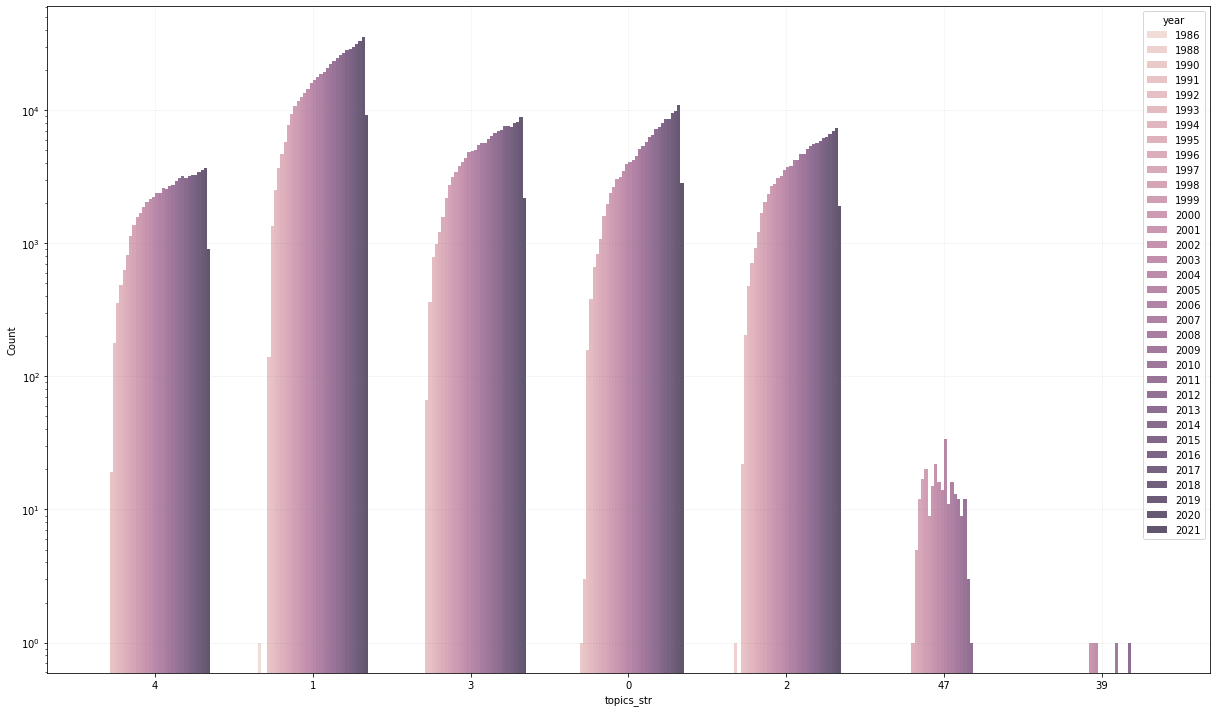

In [139]:
sns.set_palette(sns.color_palette("tab20"))

ax = plt.figure(figsize = (17, 10))
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)

sns.histplot(test_df, 
             x = "topics_str", 
             #color = colorscale, 
             hue="year", 
             multiple="dodge", 
             #kde = True, 
             #stat= "probability", 
             shrink=.7, 
             bins= 12, 
             edgecolor=None)

plt.yscale('log') 
plt.tight_layout()
